<a href="https://colab.research.google.com/github/sairam116/pipedream/blob/master/Gender_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
le = LabelEncoder()

In [7]:
##url='https://drive.google.com/file/d/1aeQ03O5-e_CHGV4D0X0iUCPv-R4zKKC0/view?usp=sharing'
##data = pd.read_csv(url)

from google.colab import files
 
 
data = files.upload()

Saving Transformed Data Set - Sheet1.csv to Transformed Data Set - Sheet1.csv


In [10]:
# Get the data summary
import io
data = pd.read_csv(io.BytesIO(data['Transformed Data Set - Sheet1.csv']))

In [11]:
data.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


In [12]:
# Get the data summary
data.describe()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
count,66,66,66,66,66
unique,3,7,6,4,2
top,Cool,Rock,Doesn't drink,Coca Cola/Pepsi,F
freq,37,19,14,32,33


In [13]:
# List all the anomaly (same feature values but got different labels)
grouping = data.groupby(list(data.columns)[:-1]).apply(lambda x: x.Gender.nunique())
grouping[grouping.eq(2)]

Favorite Color  Favorite Music Genre  Favorite Beverage  Favorite Soft Drink
Cool            Electronic            Doesn't drink      Fanta                  2
                Rock                  Vodka              Coca Cola/Pepsi        2
dtype: int64

In [14]:
data[(data['Favorite Color']=='Cool') &
     (data['Favorite Music Genre'] == 'Rock') &
     (data['Favorite Beverage']=="Vodka") &
     (data['Favorite Soft Drink']=='Coca Cola/Pepsi')]

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F
22,Cool,Rock,Vodka,Coca Cola/Pepsi,F
40,Cool,Rock,Vodka,Coca Cola/Pepsi,M
61,Cool,Rock,Vodka,Coca Cola/Pepsi,M


In [15]:
## Preprocess the Data
# Split the features and labels
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# Change the data into one-hot encoding (for features) and change label to 0-1
X = pd.get_dummies(X)
y = le.fit_transform(y)

In [16]:
X.head()

,Favorite Color_Cool,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Electronic,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Beer,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_7UP/Sprite,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other
0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [17]:
print("Shape of new data: ", X.shape)

Shape of new data:  (66, 20)


In [18]:
## rain the Model using KFold , here we do split=5

def train_model(X_train, X_test, y_train, y_test):
  model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(20), dtype='float32'),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
  ])

  model.compile(optimizer=Adam(lr=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  # Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8, verbose=0)
  # Callback to stop training if no improvement in validation loss for certain number of epochs
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

  history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stop],
    verbose=0
  )

  tr_loss, tr_acc = model.evaluate(X_train, y_train)
  loss, accuracy = model.evaluate(X_test, y_test)

  return model, history, tr_loss, tr_acc, loss, accuracy

In [19]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

loss_arr = []
acc_arr = []
trloss_arr = []
tracc_arr = []

temp_acc = 0

for train, test in kfold.split(data):
  model, history, trloss_val, tracc_val, loss_val, acc_val = train_model(X.iloc[train], X.iloc[test], y[train], y[test])
  if acc_val > temp_acc:
    print("Model changed")
    temp_acc = acc_val
    model.save('best_model.h5')
    train_index = train
    test_index = test
    best_history = history
  trloss_arr.append(trloss_val)
  tracc_arr.append(tracc_val)
  loss_arr.append(loss_val)
  acc_arr.append(acc_val)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step - loss: 0.5932 - accuracy: 0.7857
Model changed


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step - loss: 0.4804 - accuracy: 0.8462
Model changed


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step - loss: 0.6752 - accuracy: 0.4615


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step - loss: 0.6885 - accuracy: 0.6923


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step - loss: 0.3761 - accuracy: 0.8462


In [20]:
## We have saved our model and also its train-test split index, 
## now we are going to import and do it in a different scenario

print("Train Index (Best Split): ", train_index)
print("Test Index (Best Split): ", test_index)

Train Index (Best Split):  [ 0  1  2  5  7  9 10 11 12 13 14 15 16 18 20 21 22 23 24 26 27 29 30 31
 32 33 35 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54 55 57 58 59 60
 61 62 63 64 65]
Test Index (Best Split):  [ 3  4  6  8 17 19 25 28 34 36 40 48 56]


In [21]:
#Importing the Best Data from K-Fold Iteration
modeltf = tf.keras.models.load_model('best_model.h5')

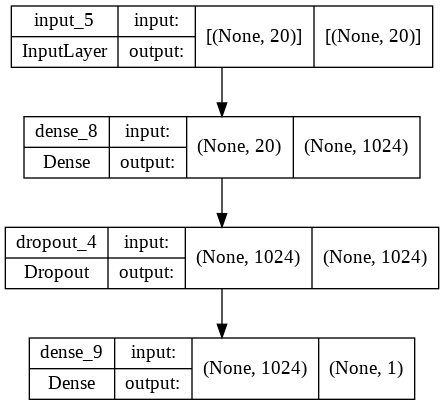

In [22]:
# Plot the model architecture
plot_model(model, show_shapes=True)

In [23]:
modeltf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              21504     
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________


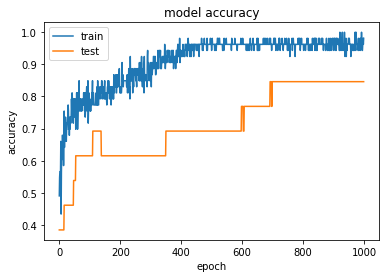

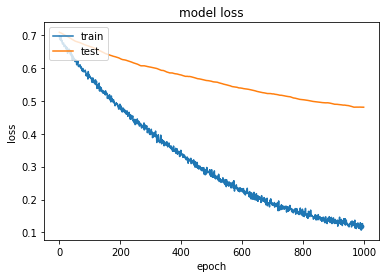

In [24]:
# Plot the accuracy of the best model for each epoch of training
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the accuracy of the best model for each epoch of loss
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Using best split from KFold
train_loss, train_acc = modeltf.evaluate(X.iloc[train_index], y[train_index])
test_loss, test_acc = modeltf.evaluate(X.iloc[test_index], y[test_index])

print("\n==============================")
print("Train Accuracy: ", train_acc)
print("Train Loss: ", train_loss)
print("==============================")
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)

1/1 [==============================] - 0s 95ms/step - loss: 0.4804 - accuracy: 0.8462

Train Accuracy:  0.9622641801834106
Train Loss:  0.1175459623336792
Test Accuracy:  0.8461538553237915
Test Loss:  0.4803647994995117


In [26]:
y_pred = modeltf.predict(X.iloc[test_index])
y_pred = (y_pred > 0.5)

In [27]:
compare_res = pd.DataFrame({
    'Y test': y[test_index],
    'Y pred': y_pred.astype(int).reshape(len(y[test_index]))
}, index=test_index)
compare_res

,Y test,Y pred
3,0,0
4,0,0
6,0,0
8,0,0
17,0,0
19,0,0
25,0,1
28,0,0
34,1,1
36,1,1


In [28]:
## wrongly classified data
wrong_res_index = compare_res[compare_res['Y test'] != compare_res['Y pred']].index.values

wrong_res = data.iloc[wrong_res_index,:]
gender_pred = np.where(wrong_res['Gender']=='F', 'M', 'F')
# wrong_res.loc[:,'Gender_Pred'] = gender_pred
wrong_res = wrong_res.assign(Gender_Pred = gender_pred)
wrong_res

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender,Gender_Pred
25,Warm,R&B and soul,Whiskey,Coca Cola/Pepsi,F,M
40,Cool,Rock,Vodka,Coca Cola/Pepsi,M,F


In [29]:
data[(data.index.isin(train_index)) &
     (data['Favorite Color'] == 'Cool') &
     (data['Favorite Music Genre'] == 'Rock') &
     (data['Favorite Beverage'] == "Vodka") &
     (data['Favorite Soft Drink'] == 'Coca Cola/Pepsi')]

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
22,Cool,Rock,Vodka,Coca Cola/Pepsi,F
61,Cool,Rock,Vodka,Coca Cola/Pepsi,M


In [30]:
data[(data.index.isin(train_index)) &
     (data['Favorite Color']=='Cool') &
     (data['Favorite Music Genre'] == 'Pop') &
     (data['Favorite Beverage'] == "Whiskey") &
     (data['Favorite Soft Drink'] == 'Fanta')]

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
38,Cool,Pop,Whiskey,Fanta,M


Text(91.68, 0.5, 'Predicted Label')

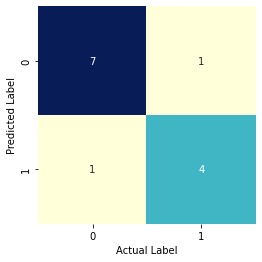

In [31]:
cm = confusion_matrix(y[test_index], y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')

In [33]:
## evaluating our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Using split scenario from train_test_split
train_loss, train_acc = modeltf.evaluate(X_train, y_train)
test_loss, test_acc = modeltf.evaluate(X_test, y_test)

print("\n==============================")
print("Train Accuracy: ", train_acc)
print("Train Loss: ", train_loss)
print("==============================")
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)

1/1 [==============================] - 0s 40ms/step - loss: 0.1023 - accuracy: 1.0000

Train Accuracy:  0.9230769276618958
Train Loss:  0.2123570740222931
Test Accuracy:  1.0
Test Loss:  0.10229354351758957


In [ ]:
## we got 1 test accuracy which is excellent 